In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal as signal

In [57]:
dg_df = pd.read_csv('Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


추후 Feature Enginnering에 이용될 계산 함수 정의

In [58]:

###### ACC
# 가속도 벡터 magnitude 계산 함수
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = np.sqrt(acc_x ** 2 + acc_y ** 2 + acc_z ** 2)
    return acc_mag

###### Activity bouts
def exercisepts(acc, hr, time): #acc and hr must be same length, acc must be magnitude
    """
        calculates activity bouts using accelerometry and heart rate
        Args:
            acc (pandas.DataFrame column or pandas series): accelerometry column
            hr (pandas.DataFrame column or pandas series): heart rate column
            time (pandas.DataFrame column or pandas series): time column
        Returns:
            countbouts (IntegerType): the number of acitvity bouts total
            returndf (pandas.DataFrame): a pandas dataframe with time and activity bouts (designated as a '1') to easily integrate with your data workflow
    """  
    
    exercisepoints = []
    for z in range(len(acc)):
        if acc.iloc[z] > np.mean(acc.iloc[0:z]):
            if hr.iloc[z] > np.mean(hr.iloc[0:z]):
                exercisepoints.append(1)
            else:
                exercisepoints.append(0)
        else:
            exercisepoints.append(0)
            
    returndf = pd.DataFrame()
    returndf['datetime'] = time
    returndf['Activity Bouts'] = exercisepoints
    
    countbouts = len(exercisepoints)
    return countbouts, returndf

###### EDA
def peak_eda(eda):
    peaks_idx, properties = find_peaks(eda, height=0, distance=4, prominence=0.3)
    peak_eda = len(peaks_idx)
    return peak_eda

'''
# rolling window에서 피크를 찾는 함수
def find_peaks_in_rolling_window(data, window_size):
    number_of_windows = 0
    peaks_in_window = 0
    for window_data in data.rolling(window=window_size):
        peaks, _ = find_peaks(window_data[' eda'], height=0, distance=4, prominence=0.3)
        if peaks.any():
            peaks_in_window += len(peaks)
        number_of_windows += 1
    return number_of_windows, peaks_in_window
'''

# PersHigh, PersLow, PersNorm 분류 함수
def classify_glucose(value, mean, std):
    if value > mean + std:
        return 'PersHigh'
    elif value < mean - std:
        return 'PersLow'
    else:
        return 'PersNorm'
    
###### IBI
def nn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    nn50 = round(n,1)
    return nn50

def pnn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    p=0
    if len(differences) != 0:
        p = (n / len(differences)) * 100
    pnn50 = round(p, 1)
    return pnn50

def rmssd(ibi):
    differences = abs(np.diff(ibi))
    rmssd = 0
    if len(differences) != 0:
        rmssd = np.sqrt(np.sum(np.square(differences)) / len(differences))
    rmssd = round(rmssd,1)
    return rmssd

def sdnn(ibi):
    if ibi.isnull().any():
        return np.nan
    #return round(np.sqrt(np.var(ibi, ddof=1)) * 10) / 10
    return round(np.sqrt(np.var(ibi, ddof=1)), 1)

###### circaidan rhythm
def crhythm(time, timeformat='%Y-%m-%d %H:%M:%S'):
    """
        computes 'minutes from midnight' and 'hours from midnight'- these features will allow you to account for circaidan rhythm effects
        Args:
             time (pandas.DataFrame): time column
             timeformat (String): default = '%Y-%m-%d %H:%M:%S.%f'; format of timestamp in time column
        Returns:
            hourfrommid (ListType): Hours from midnight, the same length as your time column
            minfrommid (ListType): Minutes from midnight, the same length as your time column

    """
    
    df = pd.DataFrame()
    df['Time'] =  pd.to_datetime(time, format=timeformat)
    df['Timefrommidnight'] =  df['Time'].dt.time
    hourfrommid=[]
    minfrommid=[]
    
    for i in range(0, len(df['Timefrommidnight'])):
        if pd.isna(df['Timefrommidnight'].iloc[i]):
            minfrommid.append(0)
            hourfrommid.append(0)
        else:
            minfrommid.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
            hourfrommid.append(round((int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))/60))

    return hourfrommid, minfrommid

# Wake Time을 감지하는 함수를 정의합니다.
def detect_wake_time(data, threshold=0.04, post_wake_duration='75m', initial_check_duration='25m'):
    wake_times = pd.Series(0, index=data.index)
    
    for timestamp in data.index:
        if timestamp != data.index[0] and data.loc[timestamp, 'rolling_slope'] > threshold:
            #print(data.loc[timestamp, 'rolling_slope'])
            initial_check_end = timestamp + pd.Timedelta(initial_check_duration)
            post_wake_end = timestamp + pd.Timedelta(post_wake_duration)
            if data.loc[initial_check_end:post_wake_end, 'rolling_avg'].mean() > data.loc[timestamp, 'rolling_avg']:
                wake_times.loc[timestamp] = 1

    return wake_times

# 데이터 로드 및 리샘플링 함수
def load_and_resample_data(file_path, original_sampling_rate, new_sampling_rate):
    data = pd.read_csv(file_path)
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)  # 인덱스를 datetime으로 설정
    
    duration = (data.index[-1] - data.index[0]).total_seconds()
    num_samples = int(duration * new_sampling_rate) + 1
    resampled_eda = signal.resample(data[' eda'].values, num_samples)
    resampled_index = pd.date_range(start=data.index[0], periods=num_samples, freq=pd.Timedelta(seconds=1/new_sampling_rate))
    resampled_data = pd.DataFrame({' eda': resampled_eda}, index=resampled_index)
    
    resampled_data['datetime'] = resampled_data.index  # datetime 인덱스를 다시 열로 추가
    
    return resampled_data

# 데이터 분석 함수
def analyze_data(eda_window, new_sampling_rate):
    # EDA 신호 처리
    
    minimum_points = 3000  # 최소 데이터 포인트 수 설정 (예: 5분 동안의 데이터)

    if len(eda_window) < minimum_points:
        # 최소 데이터 포인트 수를 충족하지 않으면 0으로 채움
        return pd.Series({
            'EDA_Tonic_SD': 0,
            'EDA_Sympathetic': 0,
            'EDA_SympatheticN': 0,
            'EDA_Autocorrelation': 0
        })
    eda_signals, info = nk.eda_process(eda_window[' eda'], sampling_rate=new_sampling_rate)
    # EDA 신호 분석
    analyzed_data = nk.eda_analyze(eda_signals, sampling_rate=new_sampling_rate)
    analyzed_data = analyzed_data.fillna(0)
    return analyzed_data

In [59]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'eat',
    'eatcnt2hr',
    'eatcnt8hr',
    'eatcnt24hr',
    'eatmean2hr',
    'eatmean8hr',
    'eatmean24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'acc_mean_2hrs',
    'acc_max_2hrs',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew',
    'Activity_bouts',
    'Activity24',
    'Activity1hr',
    'Minfrommid',
    'Hourfrommid',
    'EDA_Tonic_SD', 
    'EDA_Sympathetic', 
    'EDA_SympatheticN',
    'EDA_Autocorrelation'
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00, 2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.
* 중요 : 007 데이터셋의 Food_Log 날짜가 다른 데이터셋들의 측정 날짜와 전혀 일치하지 않음.

In [60]:
def validate_daily_dfs(daily_dfs):
    diff_set = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    dexcomset = set()
    
    # 기존 데이터 세트
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    for idx in range(len(daily_dfs['dexcom'])):
        dexcomset = dexcomset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date))
    
    # EDA 관련 데이터 세트 추가
    for idx in range(len(daily_dfs['EDA_Tonic_SD'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['EDA_Tonic_SD'][idx].index.date))
    for idx in range(len(daily_dfs['EDA_Sympathetic'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['EDA_Sympathetic'][idx].index.date))
    for idx in range(len(daily_dfs['EDA_Autocorrelation'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['EDA_Autocorrelation'][idx].index.date))

    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = diff_set.union(dexcomset.difference(accset))
    diff_set = diff_set.union(dexcomset.difference(edaset))
    diff_set = diff_set.union(dexcomset.difference(hrset))
    diff_set = diff_set.union(dexcomset.difference(ibiset))
    diff_set = diff_set.union(dexcomset.difference(tempset))
    print(diff_set)

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]
        
        if len(diff_set & dexcomset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['dexcom'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            daily_dfs['dexcom'] = [daily_dfs['dexcom'][i] for i in range(len(daily_dfs['dexcom'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs


24시간 윈도우

In [61]:
ibimultiplier = 1000 # Transform ibi to milliseconds

In [62]:
for id in range(1, len(dg_df)+1):
    if id == 7: # Skip ID 7
        continue
    
    fl_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/EDA_{id:03}.csv')
    #bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    print(f'ID : {id}')

    ## datetime 변환 및 리샘플링 전처리
    ## Dexcom Gluecose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    ## Food Log
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()
    
    ## Accelerometer
    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_df['vector_mag'] = calculate_mag(acc_df[' acc_x'], acc_df[' acc_y'], acc_df[' acc_z'])
    acc_df.drop(columns=[' acc_x', ' acc_y', ' acc_z'], inplace=True)
    acc_resampled = pd.DataFrame()
    acc_resampled['ACC_Mean'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').mean().interpolate(method='time')
    acc_resampled['ACC_Std'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').std().interpolate(method='time')
    acc_resampled['ACC_Min'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').min().interpolate(method='time')
    acc_resampled['ACC_Max'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').max().interpolate(method='time')
    acc_resampled['ACC_Q1G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.25).interpolate(method='time')
    acc_resampled['ACC_Q3G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.75).interpolate(method='time')
    acc_resampled['ACC_Skew'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').apply(lambda x: x.skew()).interpolate(method='time')
    
    #sampling_rate
    original_sampling_rate=4
    new_sampling_rate=10
    ## EDA
    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = pd.DataFrame()
    eda_resampled['EDA_Mean'] = eda_df.set_index('datetime')[' eda'].resample('5Min').mean().interpolate(method='time')
    eda_resampled['EDA_Std'] = eda_df.set_index('datetime')[' eda'].resample('5Min').std().interpolate(method='time')
    eda_resampled['EDA_Min'] = eda_df.set_index('datetime')[' eda'].resample('5Min').min().interpolate(method='time')
    eda_resampled['EDA_Max'] = eda_df.set_index('datetime')[' eda'].resample('5Min').max().interpolate(method='time')
    eda_resampled['EDA_Q1G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.25).interpolate(method='time')
    eda_resampled['EDA_Q3G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.75).interpolate(method='time')
    eda_resampled['EDA_Skew'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: eda.skew()).interpolate(method='time')
    eda_resampled['peakEDA'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: peak_eda(eda)).interpolate(method='time')
    
    eda_resampled2 = load_and_resample_data(f'F:/engineering-digital-biomarkers-main/{id:03}/EDA_{id:03}.csv', 4, new_sampling_rate)
    print(eda_resampled2.columns)
     # 새로운 분석 컬럼 추가
    eda_resampled['EDA_Tonic_SD'] = eda_resampled2.set_index('datetime')[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Tonic_SD'].mean()).interpolate(method='time')
    eda_resampled['EDA_Sympathetic'] = eda_resampled2.set_index('datetime')[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Sympathetic'].mean()).interpolate(method='time')
    eda_resampled['EDA_SympatheticN'] = eda_resampled2.set_index('datetime')[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_SympatheticN'].mean()).interpolate(method='time')
    eda_resampled['EDA_Autocorrelation'] = eda_resampled2.set_index('datetime')[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Autocorrelation'].mean()).interpolate(method='time')

 

    
    ## Heart Rate
    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = pd.DataFrame()
    hr_resampled['HR_Mean'] = hr_df.set_index('datetime')[' hr'].resample('5Min').mean().interpolate(method='time')
    hr_resampled['HR_Std'] = hr_df.set_index('datetime')[' hr'].resample('5Min').std().interpolate(method='time')
    hr_resampled['HR_Min'] = hr_df.set_index('datetime')[' hr'].resample('5Min').min().interpolate(method='time')
    hr_resampled['HR_Max'] = hr_df.set_index('datetime')[' hr'].resample('5Min').max().interpolate(method='time')
    hr_resampled['HR_Q1G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.25).interpolate(method='time')
    hr_resampled['HR_Q3G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.75).interpolate(method='time')
    hr_resampled['HR_Skew'] = hr_df.set_index('datetime')[' hr'].resample('5Min').apply(lambda hr: hr.skew()).interpolate(method='time')
    
    ## Temperature
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = pd.DataFrame()
    temp_resampled['TEMP_Mean'] = temp_df.set_index('datetime')[' temp'].resample('5Min').mean().interpolate(method='time')
    temp_resampled['TEMP_Std'] = temp_df.set_index('datetime')[' temp'].resample('5Min').std().interpolate(method='time')
    temp_resampled['TEMP_Min'] = temp_df.set_index('datetime')[' temp'].resample('5Min').min().interpolate(method='time')
    temp_resampled['TEMP_Max'] = temp_df.set_index('datetime')[' temp'].resample('5Min').max().interpolate(method='time')
    temp_resampled['TEMP_Q1G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.25).interpolate(method='time')
    temp_resampled['TEMP_Q3G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.75).interpolate(method='time')
    temp_resampled['TEMP_Skew'] = temp_df.set_index('datetime')[' temp'].resample('5Min').apply(lambda temp: temp.skew()).interpolate(method='time')
    
    ## IBI
    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    #ibi_df[' ibi'] = ibi_df[' ibi'].interpolate(method='time')
    ibi_df[' ibi'] = ibi_df[' ibi'] * ibimultiplier # 초 -> 밀리초 단위로
    #ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled = pd.DataFrame()
    ibi_resampled['minHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').min().interpolate(method='time')
    ibi_resampled['maxHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').max().interpolate(method='time')
    ibi_resampled['medianHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').median().interpolate(method='time')
    ibi_resampled['meanHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').mean().interpolate(method='time')
    ibi_resampled['SDNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdnn(ibi)).interpolate(method='time')
    ibi_resampled['NN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: nn50(ibi)).interpolate(method='time')
    ibi_resampled['pNN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: pnn50(ibi)).interpolate(method='time')
    ibi_resampled['RMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: rmssd(ibi)).interpolate(method='time')

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[],'EDA_Tonic_SD': [], 'EDA_Sympathetic': [], 'EDA_SympatheticN': [], 'EDA_Autocorrelation': []}
    for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['EDA_Tonic_SD'].append(group[['EDA_Tonic_SD']])
        daily_dfs['EDA_Sympathetic'].append(group[['EDA_Sympathetic']])
        daily_dfs['EDA_SympatheticN'].append(group[['EDA_SympatheticN']])
        daily_dfs['EDA_Autocorrelation'].append(group[['EDA_Autocorrelation']])
    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')
        
    base_df = pd.concat(daily_dfs['dexcom'])
    
    ## *_df 이름의 데이터프레임으로 리뉴얼

    acc_df.drop(acc_df.index, inplace=True)
    eda_df.drop(eda_df.index, inplace=True)
    hr_df.drop(hr_df.index, inplace=True)
    ibi_df.drop(ibi_df.index, inplace=True)
    temp_df.drop(temp_df.index, inplace=True)

    if len(daily_dfs['acc']) > 0:
        acc_df = pd.concat(daily_dfs['acc'])
    if len(daily_dfs['eda']) > 0:
        eda_df = pd.concat(daily_dfs['eda'])
    if len(daily_dfs['hr']) > 0:   
        hr_df = pd.concat(daily_dfs['hr'])
    if len(daily_dfs['ibi']) > 0:
        ibi_df = pd.concat(daily_dfs['ibi'])
    if len(daily_dfs['temp']) > 0:
        temp_df = pd.concat(daily_dfs['temp'])
    
    ###### activitybouts
    print(f'len acc == hr : {len(acc_df) == len(hr_df)}')
    if len(acc_df) != len(hr_df):
        print(f"acc : {acc_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {acc_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(acc_df)}")
        print(f"hr : {hr_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {hr_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(hr_df)}")
        # Get the intersection of the indices
        common_index = acc_df.index.intersection(hr_df.index)
        # Filter both dataframes to only include the common indices
        acc_df = acc_df.loc[common_index]
        hr_df = hr_df.loc[common_index]
        print(f'After preprocessing-> len acc == hr : {len(acc_df) == len(hr_df)}')

    resultlen , returndf = exercisepts(acc_df['ACC_Mean'], hr_df['HR_Mean'], acc_df.index)
    acc_df['Activity_bouts'] = returndf['Activity Bouts'].values


    ## 윈도우 크기 설정
    window_size = '24h'

    ## 각 타임스탬프에 대해 24시간 롤링 윈도우를 계산
    for timestamp in base_df.index:
        window_start = timestamp - pd.Timedelta(window_size)
        window_end = timestamp 
        
        if window_start < base_df.index[0]:
            continue

        # df_glucose의 롤링 윈도우 범위 내의 데이터 선택
        glucose_window = base_df.loc[window_start:window_end]
        # df_other의 동일한 범위 내의 데이터 선택
        fl_window = fl_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        acc_window = acc_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        eda_window = eda_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        hr_window = hr_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        ibi_window = ibi_df.loc[window_start:window_end]# - pd.Timedelta('5m')]
        temp_window = temp_df.loc[window_start:window_end]# - pd.Timedelta('5m')]


        ##### Wake Time
        # 1. 현재 값이 Historical 평균보다 작은지 확인
        '''
        hr_historical = hr_window
        acc_historical = acc_window
        hr_mean_avg = hr_historical['HR_Mean'].mean()
        hr_std_avg = hr_historical['HR_Std'].mean()
        acc_mean_avg = acc_historical['ACC_Mean'].mean()
        acc_std_avg = acc_historical['ACC_Std'].mean()
        '''
        specific_date = timestamp.date()

        # 해당 날짜의 데이터 필터링 및 평균 계산
        hr_daily = hr_df[hr_df.index.date == specific_date]
        acc_daily = acc_df[hr_df.index.date == specific_date]
        
        hr_mean_avg = hr_daily.loc[:window_end]['HR_Mean'].mean()
        hr_std_avg = hr_daily.loc[:window_end]['HR_Std'].mean()
        acc_mean_avg = acc_daily.loc[:window_end]['ACC_Mean'].mean()
        acc_std_avg = acc_daily.loc[:window_end]['ACC_Std'].mean()
        
        base_df.loc[window_end, 'points'] = (
            (hr_window.iloc[-1]['HR_Mean'] < hr_mean_avg).astype(int) +
            (hr_window.iloc[-1]['HR_Std'] < hr_std_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Mean'] < acc_mean_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Std'] < acc_std_avg).astype(int)
        )

        # 2. 점수가 2보다 크면 이진 값을 할당합니다.
        base_df.loc[window_end, 'binary'] = (base_df.loc[window_end, 'points'] < 2).astype(int)

        # 3시간 동안의 데이터를 이동 평균(rolling)으로 계산합니다.
        # 데이터가 5분 간격이라고 가정하면, 3시간은 36 interval입니다.
        rolling_window3hr = base_df.loc[window_end - pd.Timedelta('3hr'):window_end]
        base_df.loc[window_end, 'rolling_avg'] = rolling_window3hr['binary'].mean()
                

        ##### fl

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.
        
        flwindow5min = fl_window[window_end - pd.Timedelta('5m') : window_end]# - pd.Timedelta('5m')]
        flwindow2hr = fl_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        flwindow8hr = fl_window[window_end - pd.Timedelta('8h') : window_end]# - pd.Timedelta('5m')]
        flwindow24hr = fl_window[window_end - pd.Timedelta('24h') : window_end]# - pd.Timedelta('5m')]

        eat = 0
        if len(flwindow5min) > 0:
            eat = 1
        eatcnt2hr = len(flwindow2hr)
        eatcnt8hr = len(flwindow8hr)
        eatcnt24hr = len(flwindow24hr)

        eatmean2hr = eatcnt2hr / (2 * 60 / 5)  # 2시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean8hr = eatcnt8hr / (8 * 60 / 5)  # 8시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean24hr = eatcnt24hr / (24 * 60 / 5)  # 24시간 동안 5분 간격으로 나눈 시간 간격 수
        
        calories2hr = flwindow2hr['calorie'].values.sum()
        protein2hr = flwindow2hr['protein'].values.sum()
        sugar2hr = flwindow2hr['sugar'].values.sum()
        carbs2hr = flwindow2hr['total_carb'].values.sum()
        
        calories8hr = flwindow8hr['calorie'].values.sum()
        protein8hr = flwindow8hr['protein'].values.sum()
        sugar8hr = flwindow8hr['sugar'].values.sum()
        carbs8hr = flwindow8hr['total_carb'].values.sum()
        
        calories24hr = fl_window['calorie'].values.sum()
        protein24hr = fl_window['protein'].values.sum()
        sugar24hr = fl_window['sugar'].values.sum()
        carbs24hr = fl_window['total_carb'].values.sum()
        
        #print(f"window : [{(window_end - pd.Timedelta('24h')).strftime('%Y-%m-%d %H:%M:%S')} ~ {(window_end - pd.Timedelta('5m')).strftime('%Y-%m-%d %H:%M:%S')}]")
        #print(f"[{window24hr.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {window24hr.index[-1].strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")

        ###### acc
        accwindow2hr = acc_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]
        accwindow1hr = acc_window[window_end - pd.Timedelta('1h') : window_end]# - pd.Timedelta('5m')]

        acc_mean_2hrs = accwindow2hr['ACC_Mean'].values.mean()
        acc_max_2hrs = accwindow2hr['ACC_Max'].values.max()

        activity24 = acc_window['Activity_bouts'].values.mean()
        activity1hr = accwindow1hr['Activity_bouts'].values.sum()

        ###### eda

        # peak detection
        edawindow2hr = eda_window[window_end - pd.Timedelta('2h') : window_end]# - pd.Timedelta('5m')]

        peakEDA2hr_sum = edawindow2hr['peakEDA'].values.sum()
        peakEDA2hr_mean = edawindow2hr['peakEDA'].values.mean()

        ##### results
        #print(f"(end of window): {window_end}, glucose: {glucose_window['glucose']}, sugar24hr: {sugar24hr}")
        # df_glucose의 개인화된 평균 및 표준 편차 계산 -> Class를 나누는 값 계산
        #print(f"[{window_start.strftime('%Y-%m-%d %H:%M:%S')} ~ {window_end.strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")
        base_df.loc[window_end, 'datetime'] = window_end.strftime('%Y-%m-%d %H:%M:%S')
        base_df.loc[window_end, 'personalMean'] = glucose_window['glucose'].mean()
        base_df.loc[window_end, 'personalStd'] = glucose_window['glucose'].std()
        base_df.loc[window_end, 'ID']=id
        base_df.loc[window_end, 'HbA1c']=hbA1c
        base_df.loc[window_end, 'Biological Sex']=biological_sex
        base_df.loc[window_end, 'calories2hr']=round(calories2hr,2)
        base_df.loc[window_end, 'protein2hr']=round(protein2hr,2)
        base_df.loc[window_end, 'sugar2hr']=round(sugar2hr,2)
        base_df.loc[window_end, 'carbs2hr']=round(carbs2hr,2)
        base_df.loc[window_end, 'calories8hr']=round(calories8hr,2)
        base_df.loc[window_end, 'protein8hr']=round(protein8hr,2)
        base_df.loc[window_end, 'sugar8hr']=round(sugar8hr,2)
        base_df.loc[window_end, 'carbs8hr']=round(carbs8hr,2)
        base_df.loc[window_end, 'calories24hr']=round(calories24hr,2)
        base_df.loc[window_end, 'protein24hr']=round(protein24hr,2)
        base_df.loc[window_end, 'sugar24hr']=round(sugar24hr,2)
        base_df.loc[window_end, 'carbs24hr']=round(carbs24hr,2)
        base_df.loc[window_end, 'eat']=eat
        base_df.loc[window_end, 'eatcnt2hr']=eatcnt2hr
        base_df.loc[window_end, 'eatcnt8hr']=eatcnt8hr
        base_df.loc[window_end, 'eatcnt24hr']=eatcnt24hr
        base_df.loc[window_end, 'eatmean2hr']=eatmean2hr
        base_df.loc[window_end, 'eatmean8hr']=eatmean8hr
        base_df.loc[window_end, 'eatmean24hr']=eatmean24hr
        base_df.loc[window_end, 'acc_mean']=round(acc_window.iloc[-1]['ACC_Mean'],2)
        base_df.loc[window_end, 'acc_std']=round(acc_window.iloc[-1]['ACC_Std'],2)
        base_df.loc[window_end, 'acc_min']=round(acc_window.iloc[-1]['ACC_Min'],2)
        base_df.loc[window_end, 'acc_max']=round(acc_window.iloc[-1]['ACC_Max'],2)
        base_df.loc[window_end, 'acc_q1g']=round(acc_window.iloc[-1]['ACC_Q1G'],2)
        base_df.loc[window_end, 'acc_q3g']=round(acc_window.iloc[-1]['ACC_Q3G'],2)
        base_df.loc[window_end, 'acc_skew']=round(acc_window.iloc[-1]['ACC_Skew'],2)
        base_df.loc[window_end, 'acc_mean_2hrs']=round(acc_mean_2hrs,2)
        base_df.loc[window_end, 'acc_max_2hrs']=round(acc_max_2hrs,2)
        base_df.loc[window_end, 'eda_mean']=round(eda_window.iloc[-1]['EDA_Mean'],2)
        base_df.loc[window_end, 'eda_std']=round(eda_window.iloc[-1]['EDA_Std'],2)
        base_df.loc[window_end, 'eda_min']=round(eda_window.iloc[-1]['EDA_Min'],2)
        base_df.loc[window_end, 'eda_max']=round(eda_window.iloc[-1]['EDA_Max'],2)
        base_df.loc[window_end, 'eda_q1g']=round(eda_window.iloc[-1]['EDA_Q1G'],2)
        base_df.loc[window_end, 'eda_q3g']=round(eda_window.iloc[-1]['EDA_Q3G'],2)
        base_df.loc[window_end, 'eda_skew']=round(eda_window.iloc[-1]['EDA_Skew'],2)
        
        base_df.loc[window_end, 'EDA_Tonic_SD']=round(eda_window.iloc[-1]['EDA_Tonic_SD'],2)
        base_df.loc[window_end, 'EDA_Sympathetic']=round(eda_window.iloc[-1]['EDA_Sympathetic'],2)
        base_df.loc[window_end, 'EDA_SympatheticN']=round(eda_window.iloc[-1]['EDA_SympatheticN'],2)
        base_df.loc[window_end, 'EDA_Autocorrelation']=round(eda_window.iloc[-1]['EDA_Autocorrelation'],2)
        
 

        
        base_df.loc[window_end, 'PeakEDA']=eda_window.iloc[-1]['peakEDA']
        base_df.loc[window_end, 'PeakEDA2hr_sum']=round(peakEDA2hr_sum,2)
        base_df.loc[window_end, 'PeakEDA2hr_mean']=round(peakEDA2hr_mean,2)
        base_df.loc[window_end, 'hr_mean']=round(hr_window.iloc[-1]['HR_Mean'],2)
        base_df.loc[window_end, 'hr_std']=round(hr_window.iloc[-1]['HR_Std'],2)
        base_df.loc[window_end, 'hr_min']=round(hr_window.iloc[-1]['HR_Min'],2)
        base_df.loc[window_end, 'hr_max']=round(hr_window.iloc[-1]['HR_Max'],2)
        base_df.loc[window_end, 'hr_q1g']=round(hr_window.iloc[-1]['HR_Q1G'],2)
        base_df.loc[window_end, 'hr_q3g']=round(hr_window.iloc[-1]['HR_Q3G'],2)
        base_df.loc[window_end, 'hr_skew']=round(hr_window.iloc[-1]['HR_Skew'],2)
        base_df.loc[window_end, 'maxHRV']=round(ibi_window.iloc[-1]['maxHRV'],2)
        base_df.loc[window_end, 'minHRV']=round(ibi_window.iloc[-1]['minHRV'],2)
        base_df.loc[window_end, 'medianHRV']=round(ibi_window.iloc[-1]['medianHRV'],2)
        base_df.loc[window_end, 'meanHRV']=round(ibi_window.iloc[-1]['meanHRV'],2)
        base_df.loc[window_end, 'SDNN']=round(ibi_window.iloc[-1]['SDNN'],2)
        base_df.loc[window_end, 'NN50']=round(ibi_window.iloc[-1]['NN50'],2)
        base_df.loc[window_end, 'pNN50']=round(ibi_window.iloc[-1]['pNN50'],2)
        base_df.loc[window_end, 'RMSSD']=round(ibi_window.iloc[-1]['RMSSD'],2)
        base_df.loc[window_end, 'temp_mean']=round(temp_window.iloc[-1]['TEMP_Mean'],2)
        base_df.loc[window_end, 'temp_std']=round(temp_window.iloc[-1]['TEMP_Std'],2)
        base_df.loc[window_end, 'temp_min']=round(temp_window.iloc[-1]['TEMP_Min'],2)
        base_df.loc[window_end, 'temp_max']=round(temp_window.iloc[-1]['TEMP_Max'],2)
        base_df.loc[window_end, 'temp_q1g']=round(temp_window.iloc[-1]['TEMP_Q1G'],2)
        base_df.loc[window_end, 'temp_q3g']=round(temp_window.iloc[-1]['TEMP_Q3G'],2)
        base_df.loc[window_end, 'temp_skew']=round(temp_window.iloc[-1]['TEMP_Skew'],2)
        base_df.loc[window_end, 'Activity_bouts']=acc_window.iloc[-1]['Activity_bouts']
        base_df.loc[window_end, 'Activity24']=activity24
        base_df.loc[window_end, 'Activity1hr']=activity1hr


    ###### crhythm
    hrfrommid, minfrommid = crhythm(base_df['datetime'])
    base_df['Minfrommid'] = minfrommid
    base_df['Hourfrommid'] = hrfrommid


    # rolling average의 기울기(slope)를 계산합니다.
    base_df['rolling_slope'] = base_df['rolling_avg'].diff()
    # 4. 'WakeTime' 칼럼에 값을 저장합니다.
    base_df['WakeTime'] = detect_wake_time(base_df)

    # WakeTime을 확인하기 위한 출력
    wake_time_indices = base_df[base_df['WakeTime'] == 1].index.strftime('%Y-%m-%d %H:%M:%S')
    wake_times_str = ', '.join(map(str, wake_time_indices))
    print(wake_times_str)

    ###### 각 측정값을 PersHigh, PersLow, PersNorm으로 분류
    base_df['label'] = base_df.apply(
        lambda row: classify_glucose(row['glucose'], row['personalMean'], row['personalStd']), axis=1
    )

    base_df.drop(columns = ['points', 'binary', 'rolling_slope', 'rolling_avg'], inplace = True)
    base_df.drop(columns=['personalMean', 'personalStd'], inplace=True)

    df = pd.concat([df, base_df], ignore_index=True)
    

ID : 1
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-02-14 18:13:30, 2020-02-14 18:23:30, 2020-02-14 18:28:31, 2020-02-14 18:33:30, 2020-02-15 07:33:31, 2020-02-15 08:23:31, 2020-02-15 09:28:31, 2020-02-17 07:03:28, 2020-02-17 07:38:28, 2020-02-17 07:48:28, 2020-02-17 08:18:28, 2020-02-17 14:43:28, 2020-02-17 15:53:28, 2020-02-17 20:18:28, 2020-02-19 09:23:27, 2020-02-19 09:38:27, 2020-02-19 10:28:27, 2020-02-20 07:18:26, 2020-02-22 07:23:24, 2020-02-22 08:13:24
ID : 2
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-02-22 11:33:34, 2020-02-22 11:38:35, 2020-02-22 11:43:34, 2020-02-23 11:53:33, 2020-02-23 12:23:33, 2020-02-24 10:53:32, 2020-02-24 11:03:32, 2020-02-24 11:48:32, 2020-02-24 14:28:32, 2020-02-26 18:38:29, 2020-02-26 18:48:29, 2020-02-27 19:43:28, 2020-02-28 23:18:26
ID : 3
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-02-23 11:06:44, 2020-02-23 11:11:43, 2020-02-23 11:16:43, 2020-02-23 1

c:\Users\user\.conda\envs\open\lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
c:\Users\user\.conda\envs\open\lib\site-packages\neurokit2\eda\eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)


set()
len acc == hr : True
2020-03-05 18:03:01, 2020-03-05 18:18:01, 2020-03-05 18:48:01, 2020-03-05 19:03:01
ID : 8
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-03-15 14:39:50, 2020-03-15 14:59:50, 2020-03-15 15:04:50, 2020-03-15 15:09:50, 2020-03-15 15:14:50, 2020-03-15 15:19:50, 2020-03-16 09:29:49, 2020-03-16 10:04:49, 2020-03-16 18:04:47, 2020-03-17 02:14:46, 2020-03-17 03:29:46, 2020-03-17 03:34:46, 2020-03-17 03:44:46, 2020-03-17 03:54:46, 2020-03-19 06:44:41, 2020-03-19 06:49:41, 2020-03-19 06:54:41, 2020-03-19 06:59:41, 2020-03-19 07:04:41, 2020-03-19 07:14:41, 2020-03-19 07:39:41, 2020-03-20 07:19:39, 2020-03-23 08:34:31
ID : 9
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-03-22 11:41:48, 2020-03-22 11:46:48, 2020-03-22 11:51:48, 2020-03-22 11:56:48, 2020-03-23 08:11:49, 2020-03-25 09:11:46, 2020-03-27 09:51:44
ID : 10
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-03-24 05:54:15, 2020-0

c:\Users\user\.conda\envs\open\lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
c:\Users\user\.conda\envs\open\lib\site-packages\neurokit2\eda\eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)


set()
len acc == hr : False
acc : 2020-04-06 08:20:00 ~ 2020-04-16 10:10:00 : 2903
hr : 2020-04-06 08:25:00 ~ 2020-04-16 10:10:00 : 2902
After preprocessing-> len acc == hr : True
2020-04-08 09:41:06, 2020-04-09 07:56:04, 2020-04-09 23:51:02, 2020-04-10 00:01:02, 2020-04-10 00:31:02, 2020-04-10 00:51:02, 2020-04-13 07:45:56, 2020-04-13 08:10:56, 2020-04-13 23:45:55, 2020-04-14 10:45:55, 2020-04-14 10:55:55, 2020-04-15 10:00:52
ID : 12
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-05-04 18:52:11, 2020-05-04 18:57:10, 2020-05-04 19:02:11, 2020-05-04 19:07:11, 2020-05-04 19:12:11, 2020-05-06 12:17:08, 2020-05-07 06:17:07, 2020-05-07 06:42:08, 2020-05-08 09:07:05, 2020-05-08 09:32:05, 2020-05-09 07:37:03, 2020-05-09 07:52:04, 2020-05-09 08:32:04, 2020-05-09 17:37:02, 2020-05-10 14:47:01, 2020-05-11 07:36:59
ID : 13
Index([' eda', 'datetime'], dtype='object')
set()
len acc == hr : True
2020-05-31 11:46:49, 2020-05-31 12:16:49, 2020-06-02 18:56:44, 2020-06-02 19

In [63]:
'''id=1
hr_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/HR_{id:03}.csv')
if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
        hr_df.set_index('datetime', inplace=True)
print(hr_df.head())'''

"id=1\nhr_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/HR_{id:03}.csv')\nif id == 1:\n        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')\n        hr_df.set_index('datetime', inplace=True)\nprint(hr_df.head())"

In [64]:
'''
def validate_daily_dfs(daily_dfs):
    isok = True
    for key, value in daily_dfs.items():
        if len(value) == 0:
            isok = False
            daily_dfs[key] = [pd.DataFrame()]
    return isok, daily_dfs

# ID 1의 데이터만 사용
id = 1

# 데이터 로드
fl_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/Food_Log_{id:03}.csv')
acc_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/ACC_{id:03}.csv')
eda_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/EDA_{id:03}.csv')
hr_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/HR_{id:03}.csv')
ibi_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/IBI_{id:03}.csv')
temp_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/TEMP_{id:03}.csv')
dexcom_df = pd.read_csv(f'F:/engineering-digital-biomarkers-main/{id:03}/Dexcom_{id:03}.csv')

# 열 이름 확인
print(f"EDA DataFrame columns: {eda_df.columns}")
print(f"Dexcom DataFrame columns: {dexcom_df.columns}")
print(f"Food Log DataFrame columns: {fl_df.columns}")
print(f"ACC DataFrame columns: {acc_df.columns}")
print(f"HR DataFrame columns: {hr_df.columns}")
print(f"IBI DataFrame columns: {ibi_df.columns}")
print(f"TEMP DataFrame columns: {temp_df.columns}")

#

# datetime 변환 및 인덱스 설정
dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
dexcom_df = dexcom_df[['datetime', 'glucose']]
dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
dexcom_df.set_index('datetime', inplace=True)

    ## Food Log
if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
fl_df = fl_df.sort_index()

acc_df['datetime'] = pd.to_datetime(acc_df['datetime'])
acc_df.set_index('datetime', inplace=True)

if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')  
else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
        

ibi_df['datetime'] = pd.to_datetime(ibi_df['datetime'])
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])


# 기존 샘플링 속도
original_sampling_rate = 4
# 새로운 샘플링 속도
new_sampling_rate = 10

# EDA 데이터 리샘플링
eda_resampled2 = load_and_resample_data(f'F:/engineering-digital-biomarkers-main/{id:03}/EDA_{id:03}.csv', original_sampling_rate, new_sampling_rate)

# EDA 데이터 5분 간격으로 리샘플링
eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
eda_df.set_index('datetime', inplace=True)
eda_resampled = pd.DataFrame()
eda_resampled['EDA_Mean'] = eda_df[' eda'].resample('5Min').mean().interpolate(method='time')
eda_resampled['EDA_Std'] = eda_df[' eda'].resample('5Min').std().interpolate(method='time')
eda_resampled['EDA_Min'] = eda_df[' eda'].resample('5Min').min().interpolate(method='time')
eda_resampled['EDA_Max'] = eda_df[' eda'].resample('5Min').max().interpolate(method='time')
eda_resampled['EDA_Q1G'] = eda_df[' eda'].resample('5Min').quantile(0.25).interpolate(method='time')
eda_resampled['EDA_Q3G'] = eda_df[' eda'].resample('5Min').quantile(0.75).interpolate(method='time')
eda_resampled['EDA_Skew'] = eda_df[' eda'].resample('5Min').apply(lambda eda: eda.skew()).interpolate(method='time')
eda_resampled['peakEDA'] = eda_df[' eda'].resample('5Min').apply(lambda eda: peak_eda(eda)).interpolate(method='time')

# 새로운 분석 컬럼 추가
eda_resampled['EDA_Tonic_SD'] = eda_resampled2[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Tonic_SD'].mean()).interpolate(method='time')
eda_resampled['EDA_Sympathetic'] = eda_resampled2[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Sympathetic'].mean()).interpolate(method='time')
eda_resampled['EDA_SympatheticN'] = eda_resampled2[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_SympatheticN'].mean()).interpolate(method='time')
eda_resampled['EDA_Autocorrelation'] = eda_resampled2[' eda'].resample('5Min').apply(lambda x: analyze_data(pd.DataFrame({' eda': x}), new_sampling_rate)['EDA_Autocorrelation'].mean()).interpolate(method='time')

## Heart Rate

        
hr_resampled = pd.DataFrame()
hr_resampled['HR_Mean'] = hr_df.set_index('datetime')[' hr'].resample('5Min').mean().interpolate(method='time')
hr_resampled['HR_Std'] = hr_df.set_index('datetime')[' hr'].resample('5Min').std().interpolate(method='time')
hr_resampled['HR_Min'] = hr_df.set_index('datetime')[' hr'].resample('5Min').min().interpolate(method='time')
hr_resampled['HR_Max'] = hr_df.set_index('datetime')[' hr'].resample('5Min').max().interpolate(method='time')
hr_resampled['HR_Q1G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.25).interpolate(method='time')
hr_resampled['HR_Q3G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.75).interpolate(method='time')
hr_resampled['HR_Skew'] = hr_df.set_index('datetime')[' hr'].resample('5Min').apply(lambda hr: hr.skew()).interpolate(method='time')
    
    ## Temperature
temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
temp_resampled = pd.DataFrame()
temp_resampled['TEMP_Mean'] = temp_df.set_index('datetime')[' temp'].resample('5Min').mean().interpolate(method='time')
temp_resampled['TEMP_Std'] = temp_df.set_index('datetime')[' temp'].resample('5Min').std().interpolate(method='time')
temp_resampled['TEMP_Min'] = temp_df.set_index('datetime')[' temp'].resample('5Min').min().interpolate(method='time')
temp_resampled['TEMP_Max'] = temp_df.set_index('datetime')[' temp'].resample('5Min').max().interpolate(method='time')
temp_resampled['TEMP_Q1G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.25).interpolate(method='time')
temp_resampled['TEMP_Q3G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.75).interpolate(method='time')
temp_resampled['TEMP_Skew'] = temp_df.set_index('datetime')[' temp'].resample('5Min').apply(lambda temp: temp.skew()).interpolate(method='time')
    
    ## IBI
ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    #ibi_df[' ibi'] = ibi_df[' ibi'].interpolate(method='time')
ibi_df[' ibi'] = ibi_df[' ibi'] * ibimultiplier # 초 -> 밀리초 단위로
    #ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
ibi_resampled = pd.DataFrame()
ibi_resampled['minHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').min().interpolate(method='time')
ibi_resampled['maxHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').max().interpolate(method='time')
ibi_resampled['medianHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').median().interpolate(method='time')
ibi_resampled['meanHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').mean().interpolate(method='time')
ibi_resampled['SDNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdnn(ibi)).interpolate(method='time')
ibi_resampled['NN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: nn50(ibi)).interpolate(method='time')
ibi_resampled['pNN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: pnn50(ibi)).interpolate(method='time')
ibi_resampled['RMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: rmssd(ibi)).interpolate(method='time')
# 일별 데이터프레임 분할
daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'dexcom':[], 'EDA_Tonic_SD': [], 'EDA_Sympathetic': [], 'EDA_SympatheticN': [], 'EDA_Autocorrelation': []}

for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
#for name, group in acc_resampled.groupby(acc_resampled.index.date):
        #daily_dfs['acc'].append(group)
for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)
for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['EDA_Tonic_SD'].append(group[['EDA_Tonic_SD']])
        daily_dfs['EDA_Sympathetic'].append(group[['EDA_Sympathetic']])
        daily_dfs['EDA_SympatheticN'].append(group[['EDA_SympatheticN']])
        daily_dfs['EDA_Autocorrelation'].append(group[['EDA_Autocorrelation']])


isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
if not isok:
    print(f'daily_dfs is modified...')

base_df = pd.concat(daily_dfs['dexcom'])

## *_df 이름의 데이터프레임으로 리뉴얼
acc_df.drop(acc_df.index, inplace=True)
eda_df.drop(eda_df.index, inplace=True)
hr_df.drop(hr_df.index, inplace=True)
ibi_df.drop(ibi_df.index, inplace=True)
temp_df.drop(temp_df.index, inplace=True)

if len(daily_dfs['acc']) > 0:
    acc_df = pd.concat(daily_dfs['acc'])
if len(daily_dfs['eda']) > 0:
    eda_df = pd.concat(daily_dfs['eda'])
if len(daily_dfs['hr']) > 0:   
    hr_df = pd.concat(daily_dfs['hr'])
if len(daily_dfs['ibi']) > 0:
    ibi_df = pd.concat(daily_dfs['ibi'])
if len(daily_dfs['temp']) > 0:
    temp_df = pd.concat(daily_dfs['temp'])
eda_tonic_sd_df = pd.concat(daily_dfs['EDA_Tonic_SD'])
eda_sympathetic_df = pd.concat(daily_dfs['EDA_Sympathetic'])
eda_sympatheticn_df = pd.concat(daily_dfs['EDA_SympatheticN'])
eda_autocorrelation_df = pd.concat(daily_dfs['EDA_Autocorrelation'])

# 최종 데이터프레임 출력
print(base_df.head())
print(acc_df.head())
print(eda_df.head())
print(hr_df.head())
print(ibi_df.head())
print(temp_df.head())
print(eda_tonic_sd_df.head())
print(eda_sympathetic_df.head())
print(eda_sympatheticn_df.head())
print(eda_autocorrelation_df.head())


'''



'\ndef validate_daily_dfs(daily_dfs):\n    isok = True\n    for key, value in daily_dfs.items():\n        if len(value) == 0:\n            isok = False\n            daily_dfs[key] = [pd.DataFrame()]\n    return isok, daily_dfs\n\n# ID 1의 데이터만 사용\nid = 1\n\n# 데이터 로드\nfl_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/Food_Log_{id:03}.csv\')\nacc_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/ACC_{id:03}.csv\')\neda_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/EDA_{id:03}.csv\')\nhr_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/HR_{id:03}.csv\')\nibi_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/IBI_{id:03}.csv\')\ntemp_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/TEMP_{id:03}.csv\')\ndexcom_df = pd.read_csv(f\'F:/engineering-digital-biomarkers-main/{id:03}/Dexcom_{id:03}.csv\')\n\n# 열 이름 확인\nprint(f"EDA DataFrame columns: {eda_df.columns}")\nprint(f"Dexcom DataFra

In [65]:
'''print(base_df)
print(eda_df)'''


'print(base_df)\nprint(eda_df)'

In [66]:
'''print(hr_df)
print(ibi_df)'''

'print(hr_df)\nprint(ibi_df)'

In [ ]:
'''print("Base DataFrame:")
print(base_df.head())

print("\nAccelerometer DataFrame:")
print(acc_df.head())

print("\nEDA DataFrame:")
print(eda_df.head())'''

In [68]:
print(len(df))

34165


In [11]:

df[['EDA_Tonic_SD', 
    'EDA_Sympathetic', 
    'EDA_SympatheticN',
    'EDA_Autocorrelation']].isna().sum()

EDA_Tonic_SD           5053
EDA_Sympathetic        5053
EDA_SympatheticN       5053
EDA_Autocorrelation    5053
dtype: int64

In [7]:
df = df.dropna().reset_index(drop=True)

In [ ]:
df[(df['WakeTime'] == 1) & (df['ID'] == 2)].head(30)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,EDA_Tonic_SD,EDA_Sympathetic,EDA_Autocorrelation,glucose,datetime,ID,HbA1c,Biological Sex,WakeTime,label


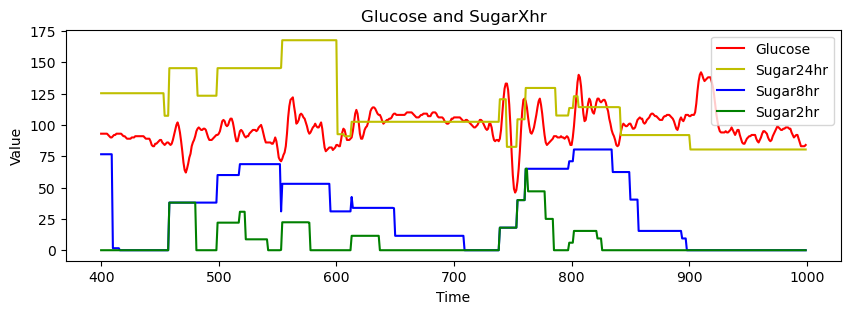

In [70]:
import matplotlib.pyplot as plt

# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['glucose'], 'r', label='Glucose')
plt.plot(filtered_df.index, filtered_df['sugar24hr'], 'y', label='Sugar24hr')
plt.plot(filtered_df.index, filtered_df['sugar8hr'], 'b', label='Sugar8hr')
plt.plot(filtered_df.index, filtered_df['sugar2hr'], 'g', label='Sugar2hr')

plt.title('Glucose and SugarXhr')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

In [71]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')

In [9]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [79]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [73]:
df.isna().sum()

Unnamed: 0           0
calories2hr       4103
protein2hr        4650
sugar2hr          4650
carbs2hr          4103
                  ... 
ID                4103
HbA1c             4103
Biological Sex    4103
WakeTime             0
label                0
Length: 77, dtype: int64

In [27]:
condition = df['calories2hr'].notna() & df['EDA_Tonic_SD'].isna()

# 조건을 만족하는 행 필터링
filtered_df = df[condition]

# 결과 출력
print(filtered_df)


       Unnamed: 0  calories2hr  protein2hr  sugar2hr  carbs2hr  calories8hr  \
30721       30721          0.0         0.0       0.0       0.0          0.0   
30722       30722          0.0         0.0       0.0       0.0          0.0   
30723       30723          0.0         0.0       0.0       0.0          0.0   
30724       30724          0.0         0.0       0.0       0.0          0.0   
30725       30725          0.0         0.0       0.0       0.0          0.0   
...           ...          ...         ...       ...       ...          ...   
31666       31666          0.0         0.0       0.0       0.0          0.0   
31667       31667          0.0         0.0       0.0       0.0          0.0   
31668       31668          0.0         0.0       0.0       0.0          0.0   
31669       31669          0.0         0.0       0.0       0.0          0.0   
31670       31670          0.0         0.0       0.0       0.0          0.0   

       protein8hr  sugar8hr  carbs8hr  calories24hr

In [30]:
filtered_dates = filtered_df['datetime']

# 결과 출력
print(filtered_dates)

30721    2020-07-20 21:13:54
30722    2020-07-20 21:18:54
30723    2020-07-20 21:23:54
30724    2020-07-20 21:28:54
30725    2020-07-20 21:33:54
                ...         
31666    2020-07-24 06:43:49
31667    2020-07-24 06:48:49
31668    2020-07-24 06:53:49
31669    2020-07-24 06:58:49
31670    2020-07-24 07:03:49
Name: datetime, Length: 950, dtype: object


In [29]:
print(filtered_df.ID)

# 결과 출력


30721    15.0
30722    15.0
30723    15.0
30724    15.0
30725    15.0
         ... 
31666    15.0
31667    15.0
31668    15.0
31669    15.0
31670    15.0
Name: ID, Length: 950, dtype: float64


In [74]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [75]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [84]:
corrdf = df.drop(columns=['datetime']).corr()

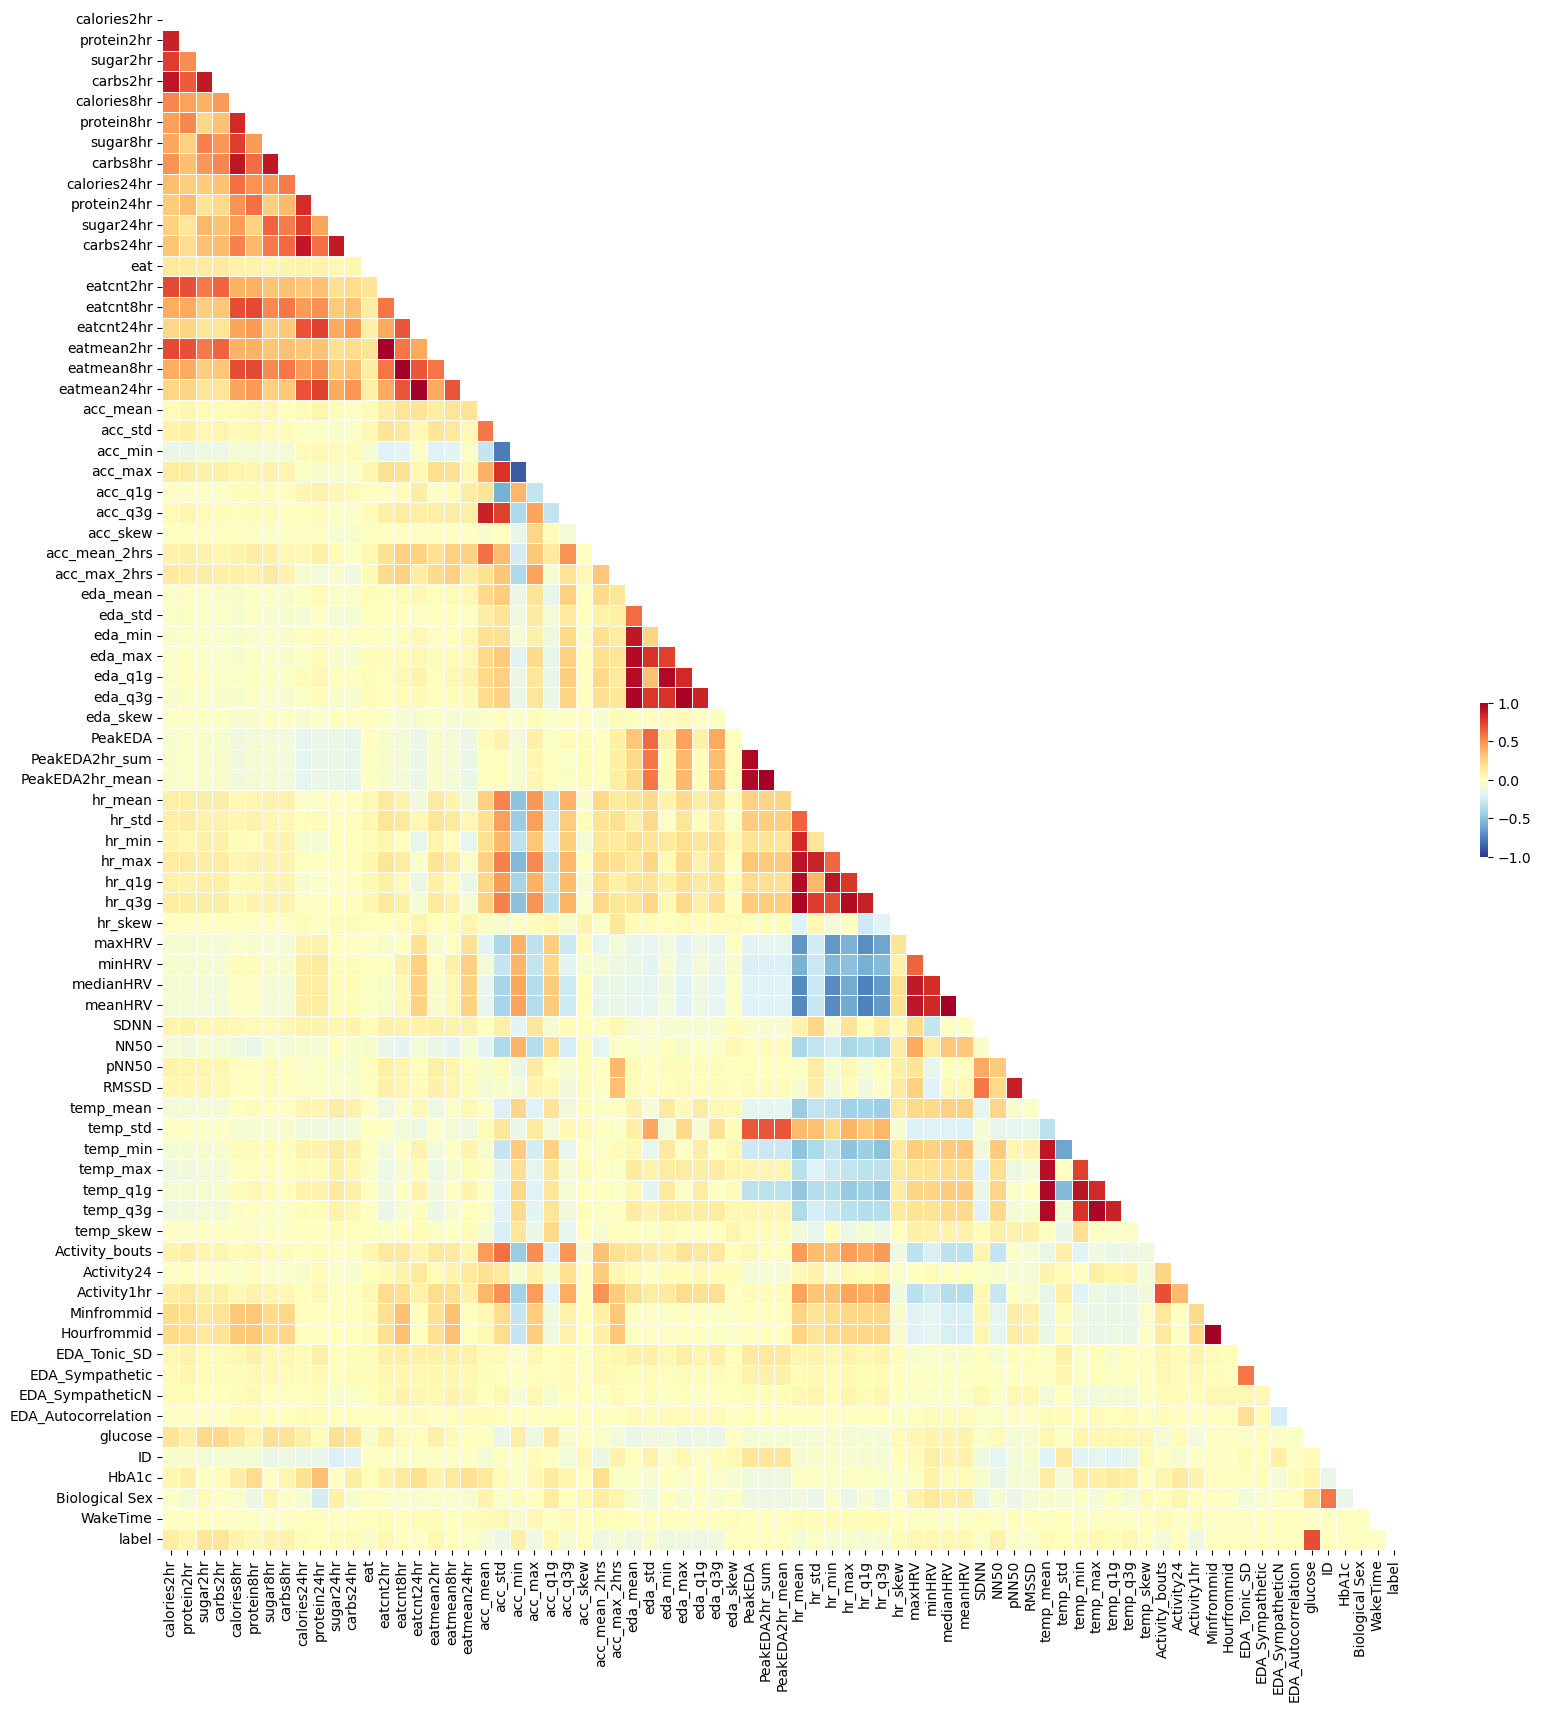

In [85]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [86]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvreg function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn]#.apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    # Instantiate LightGBM model
    lgbm_reg = LGBMRegressor(importance_type='gain')
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    lgbm_reg.fit(X_train, y_train)
    
    # Get importances:
    importances = list(lgbm_reg.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def LGBMLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features 
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = ids #str(ids)
    data[idcolumn] = data[idcolumn]#.apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here


    lgbm_reg = LGBMRegressor(importance_type='gain')# Train the model on training data
    print('Now processing... LGBMLOOCV')
    lgbm_reg.fit(X_train, y_train)
                 
    # 데이터 차원 및 비어 있는지 확인
    if X_test.ndim != 2:
        raise ValueError("Input data must be 2 dimensional.")

    if X_test.empty:
        raise ValueError("Input data must be non empty.")
    
    # Use the LightGBM predict method on the test data
    predictions = lgbm_reg.predict(X_test)
    errors = abs(predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))

    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(lgbm_reg.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return errors, RMSE, MAPerror, important, listimportances[listimportances['importances'] >= fs]

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    data[idcolumn] = data[idcolumn].astype(int)
    IDlist = list(set(data[idcolumn])) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [] #[idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    filtered_importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        er, rm, ma, imp, filteredimp = LGBMLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        importances = pd.concat([importances, imp], ignore_index=True)
        filtered_importances = pd.concat([filtered_importances, filteredimp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return errors, meanrmse, stdrmse, meanmape, stdmape, importances, filtered_importances

In [88]:
from lightgbm import LGBMRegressor
errors, RMSE, RMSEstd, MAPE, MAPEstd, importances, filtered_importances = loocvLGBMRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], fs=1.0 * 1e6)

IDlist : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
24825
2272
Now processing... LOOCV_featureselection
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14302
[LightGBM] [Info] Number of data points in the train set: 24825, number of used features: 73
[LightGBM] [Info] Start training from score 117.809507
LOOCV_O : 1
Now processing... LGBMLOOCV
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3737
[LightGBM] [Info] Number of data points in the train set: 24825, number of used features: 18
[LightGBM] [Info] Start training from score 117.809507
...1 processing complete.
25267
1830
Now processing... LOOCV_featureselection
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

In [89]:
print(importances)

              value   importances  id
0          sugar2hr  4.548952e+06   1
1          carbs2hr  2.490785e+06   1
2       calories8hr  2.371370e+06   1
3        protein8hr  2.513130e+06   1
4          sugar8hr  1.868593e+06   1
..              ...           ...  ..
250      Activity24  4.494541e+06  16
251      Minfrommid  7.187532e+06  16
252              ID  2.967053e+06  16
253           HbA1c  2.259045e+06  16
254  Biological Sex  3.579515e+06  16

[255 rows x 3 columns]


                 importances
value                       
Minfrommid      7.346053e+06
PeakEDA2hr_sum  4.375649e+06
Activity24      3.914207e+06
ID              3.714974e+06
sugar2hr        3.504396e+06
carbs2hr        3.233530e+06
acc_max_2hrs    2.983614e+06
sugar24hr       2.638576e+06
HbA1c           2.558968e+06
sugar8hr        2.473967e+06
protein24hr     2.470327e+06
acc_mean_2hrs   2.345570e+06
protein8hr      2.215029e+06
carbs8hr        2.143635e+06
carbs24hr       2.108011e+06
Biological Sex  2.092716e+06
calories24hr    2.037657e+06
calories8hr     1.974854e+06
acc_q1g         1.790766e+06
eatcnt24hr      1.435691e+06
eatcnt8hr       1.211106e+06


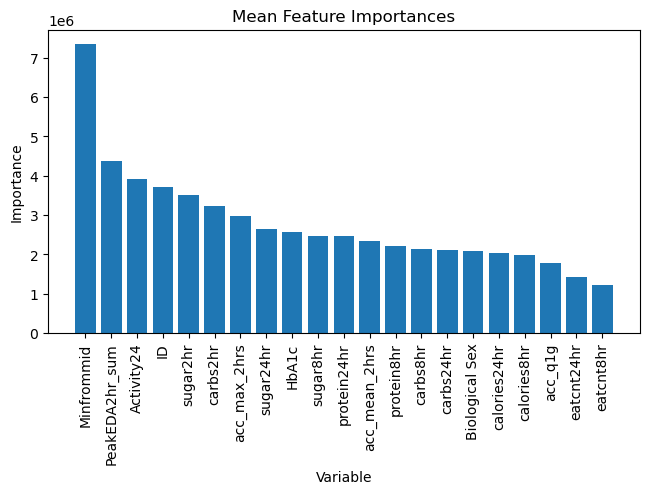

In [90]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
print(filteredimp)
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()